## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run modules.py

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

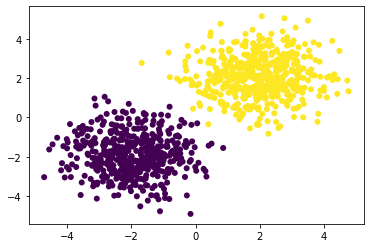

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [4]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())
print(net)

Linear 2 -> 2
LogSoftMax

Linear 2 -> 4
ReLU
Linear 4 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

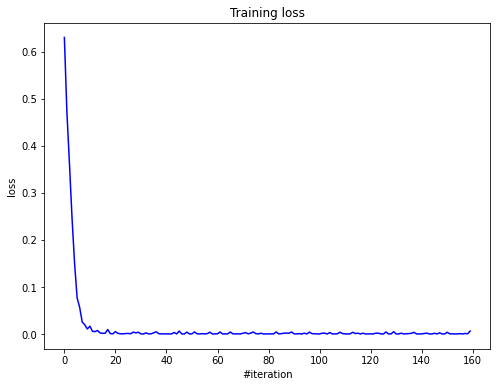

Current loss: 0.006254


In [7]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [8]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

One-hot encode the labels first.

In [9]:
# Your code goes here. ################################################
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from datetime import datetime

In [10]:
oh_encoder = OneHotEncoder()
y_train = np.array(oh_encoder.fit_transform(y_train.reshape(-1, 1)).todense()) 
y_val = np.array(oh_encoder.transform(y_val.reshape(-1, 1)).todense()) 
y_test = np.array(oh_encoder.transform(y_test.reshape(-1, 1)).todense()) 

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1]*X_val.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [31]:
# Your code goes here. ################################################
def train(model, opt, opt_config, loss_func, x_train, y_train, x_val, y_val, epochs, batch_size):
    train_losses = []
    val_losses = []
    val_accuracies = []
    optimizer_state = {}

    start = datetime.now()
    for i in range(epochs):
        for x_batch, y_batch in get_batches((x_train, y_train), batch_size):

            model.zeroGradParameters()

            predictions = model.forward(x_batch)
            loss = loss_func.forward(predictions, y_batch)

            model.backward(x_batch, loss_func.backward(predictions, y_batch))

            opt(model.getParameters(),
                model.getGradParameters(), 
                opt_config, 
                optimizer_state)      

            train_losses.append(loss)
        model.evaluate()
        preds = model.forward(x_val)
        val_losses.append(criterion.forward(preds, y_val))
        val_accuracies.append(accuracy_score([np.argmax(i) for i in preds], [np.argmax(i) for i in y_val]))
        model.train()
    exec_time = datetime.now() - start

    return train_losses, val_losses, val_accuracies, exec_time

In [32]:
def build_model(activation_func, input_size=28*28, inner=128, output_size=10):
    net = Sequential()
    net.add(Linear(input_size, inner))
    net.add(activation_func())
    net.add(Linear(inner, output_size))
    net.add(LogSoftMax())
    
    return net

In [33]:
def build_model_batch_norm(activation_func, alpha=0., input_size=28*28, inner=128, output_size=10):
    net = Sequential()
    net.add(Linear(input_size, inner))
    net.add(BatchNormalization(alpha))
    net.add(ChannelwiseScaling(inner))
    net.add(activation_func())
    net.add(BatchNormalization(alpha))
    net.add(ChannelwiseScaling(inner))
    net.add(Linear(inner, output_size))
    net.add(LogSoftMax())
    
    return net

In [34]:
def plot_results(train_loss, val_loss, val_accuracy, labels):
    plt.figure(figsize=(10, 10))
    plt.title("Training loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.yscale("log")
    for loss, label in zip(train_loss, labels):
        plt.plot(loss, label = label)
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 10))
    plt.title("Validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.yscale("log")
    for loss, label in zip(val_loss, labels):
        plt.plot(loss, label = label)
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 10))
    plt.title("Validation accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    for acc, label in zip(val_accuracy, labels):
        plt.plot(acc, label = label)
    plt.legend()
    plt.show()


Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

### Just linear layers with SGD momentum

In [35]:
# Your answer goes here. ################################################
activation_funcs = [ReLU, ELU, LeakyReLU, SoftPlus]
train_losses = []
val_losses = []
val_accuracies = []
n_epoch = 10
batch_size = 512
optimizer_config = {'learning_rate' : 1e-2, 'momentum': 0.9}
criterion = ClassNLLCriterion()

labels = ["ReLU", "ELU", "LeakyReLU", "SoftPlus"]
for i, activation_func in enumerate(activation_funcs):
    net = build_model(activation_func)
    train_loss, val_loss, val_acc, time = train(net, sgd_momentum, optimizer_config, criterion, X_train, y_train, X_val, y_val, n_epoch, batch_size)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    net.evaluate()
    preds = net.forward(X_test)
    test_acc = accuracy_score([np.argmax(i) for i in preds], [np.argmax(i) for i in y_test])
    print(f'{labels[i]}: Test accuracy: {test_acc}. Execution time per epoch: {time/n_epoch}.')



ReLU: Test accuracy: 0.9318. Execution time per epoch: 0:00:02.076981.
ELU: Test accuracy: 0.9208. Execution time per epoch: 0:00:02.432603.
LeakyReLU: Test accuracy: 0.928. Execution time per epoch: 0:00:02.608054.
SoftPlus: Test accuracy: 0.917. Execution time per epoch: 0:00:02.915908.


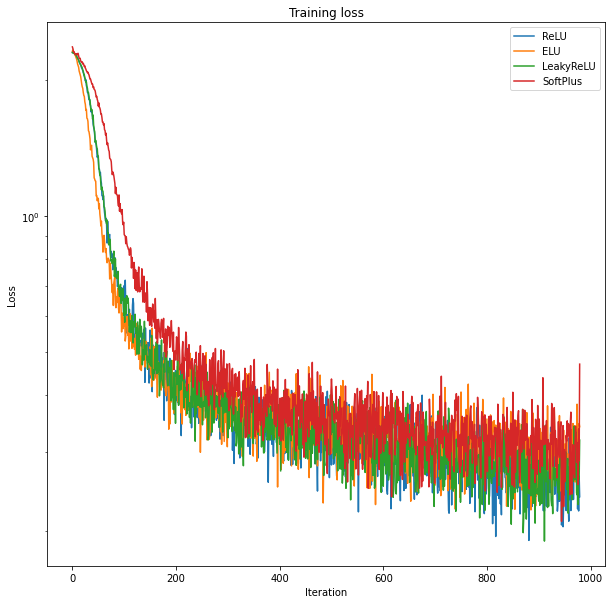

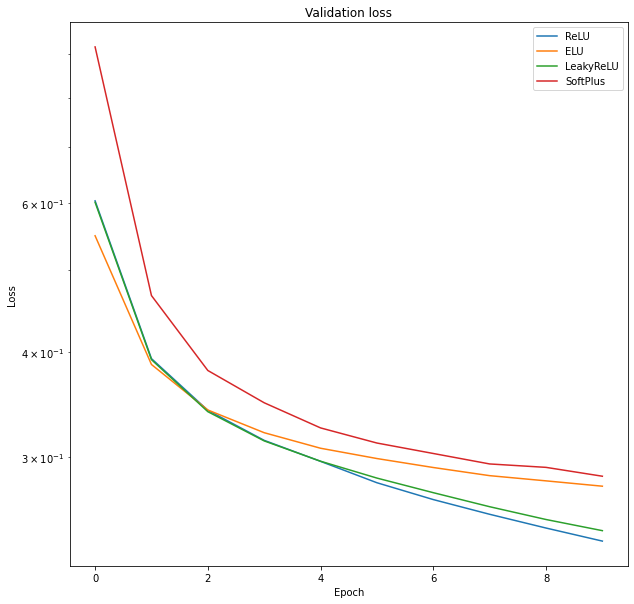

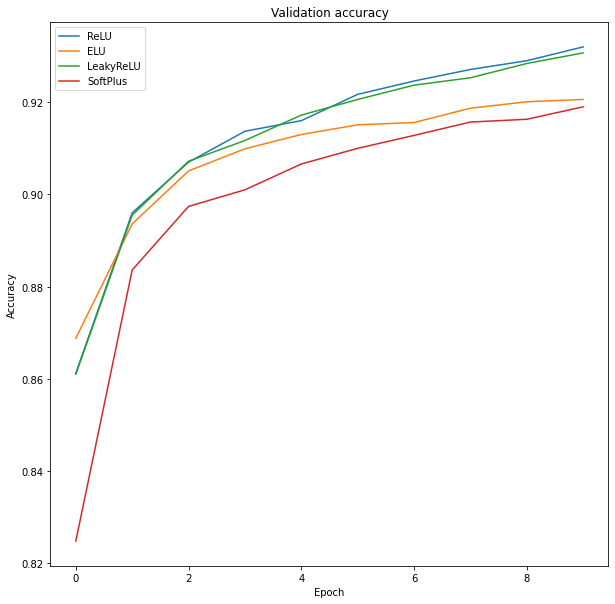

In [36]:
plot_results(np.array(train_losses), np.array(val_losses), np.array(val_accuracies), labels)

По графикам loss-ов и показателям accuracy на тестовой выборке можно заметить, что ReLU и LeakyReLU показывают наилучшие результаты. Так же заметим, что показатели accuracy на тестовой выборке больше 90%, что достаточно высоко. Посмотрим, получится ли улучшить данные показатели.

### Batch Normalisation with SGD momentum



In [37]:
activation_funcs = [ReLU, ELU, LeakyReLU, SoftPlus]
train_losses = []
val_losses = []
val_accuracies = []
n_epoch = 10
batch_size = 512
optimizer_config = {'learning_rate' : 1e-2, 'momentum': 0.9}
criterion = ClassNLLCriterion()

labels = ["ReLU", "ELU", "LeakyReLU", "SoftPlus"]
for i, activation_func in enumerate(activation_funcs):
    net = build_model_batch_norm(activation_func)
    train_loss, val_loss, val_acc, time = train(net, sgd_momentum, optimizer_config, criterion, X_train, y_train, X_val, y_val, n_epoch, batch_size)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    net.evaluate()
    preds = net.forward(X_test)
    test_acc = accuracy_score([np.argmax(i) for i in preds], [np.argmax(i) for i in y_test])
    print(f'{labels[i]}: Test accuracy: {test_acc}. Execution time per epoch: {time/n_epoch}.')

ReLU: Test accuracy: 0.9618. Execution time per epoch: 0:00:02.926350.
ELU: Test accuracy: 0.9252. Execution time per epoch: 0:00:03.126470.
LeakyReLU: Test accuracy: 0.9585. Execution time per epoch: 0:00:02.804491.
SoftPlus: Test accuracy: 0.9237. Execution time per epoch: 0:00:03.499856.


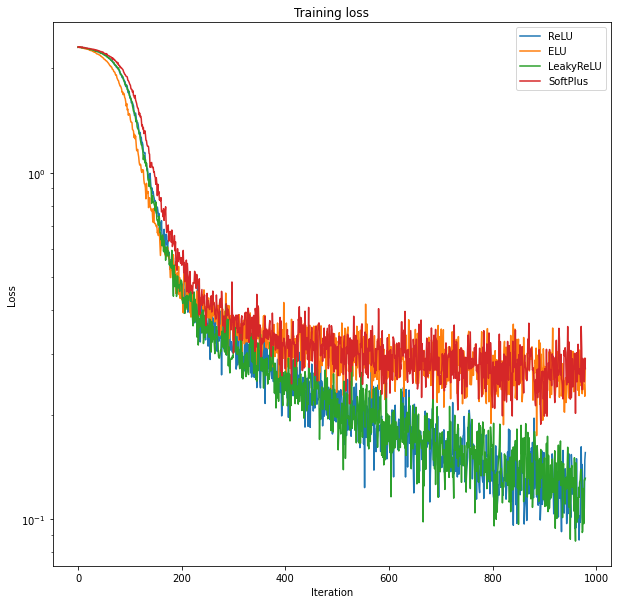

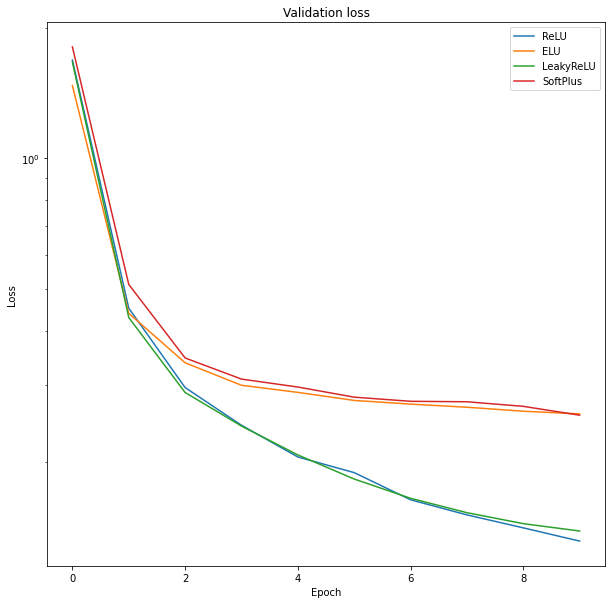

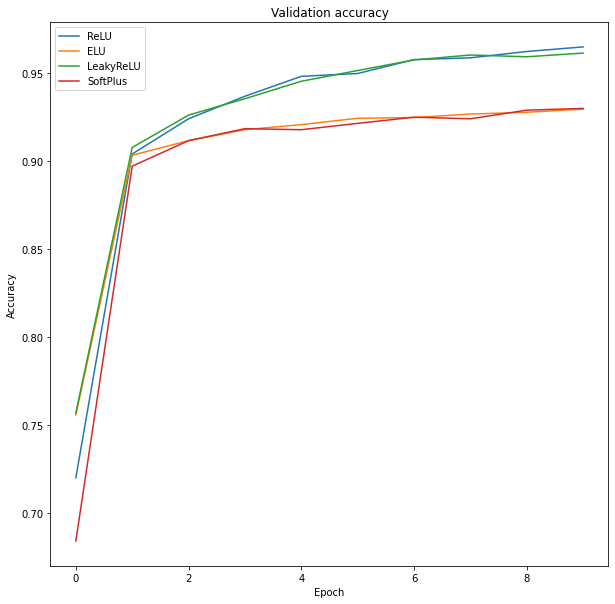

In [38]:
plot_results(np.array(train_losses), np.array(val_losses), np.array(val_accuracies), labels)

Добавление BatchNormalization не сильно влияет на время обучения модели. Одна эпоха теперь длится чуть дольше. Так же стал сильнее заметен разрыв в качестве между ReLU, LeakyReLU  и ELU и SoftPlus. При этом accuracy на теестовой выборке для ReLU и LeackyReLU выросло и слало порядка 96% (в прошлом эксперименте было примерно 93%)

### Just linear layers with Adam optimizer

In [39]:
activation_funcs = [ReLU, ELU, LeakyReLU, SoftPlus]
train_losses = []
val_losses = []
val_accuracies = []
n_epoch = 10
batch_size = 512
optimizer_config = {'learning_rate' : 1e-2, 'momentum': 0.9, 'beta1': 0.3, 'beta2': 0.9, 'epsilon': 1e-8}
criterion = ClassNLLCriterion()

labels = ["ReLU", "ELU", "LeakyReLU", "SoftPlus"]
for i, activation_func in enumerate(activation_funcs):
    net = build_model(activation_func)
    train_loss, val_loss, val_acc, time = train(net, adam_optimizer, optimizer_config, criterion, X_train, y_train, X_val, y_val, n_epoch, batch_size)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    net.evaluate()
    preds = net.forward(X_test)
    test_acc = accuracy_score([np.argmax(i) for i in preds], [np.argmax(i) for i in y_test])
    print(f'{labels[i]}: Test accuracy: {test_acc}. Execution time per epoch: {time/n_epoch}.')



ReLU: Test accuracy: 0.975. Execution time per epoch: 0:00:02.213162.
ELU: Test accuracy: 0.9709. Execution time per epoch: 0:00:02.828382.
LeakyReLU: Test accuracy: 0.9772. Execution time per epoch: 0:00:02.623182.
SoftPlus: Test accuracy: 0.9762. Execution time per epoch: 0:00:03.003889.


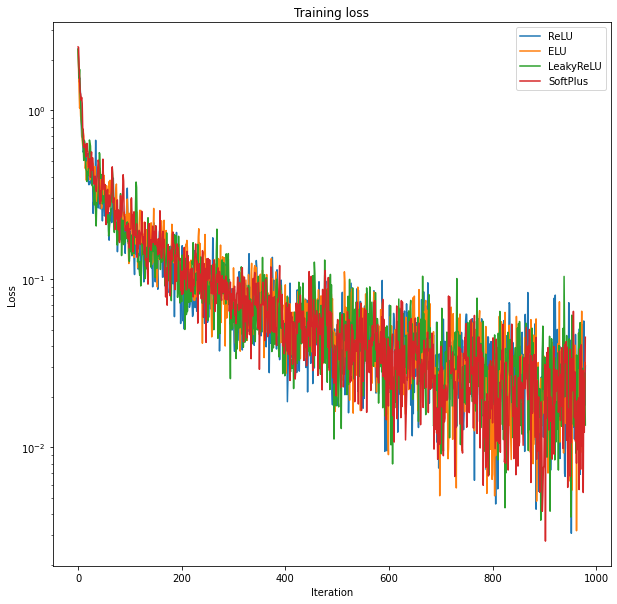

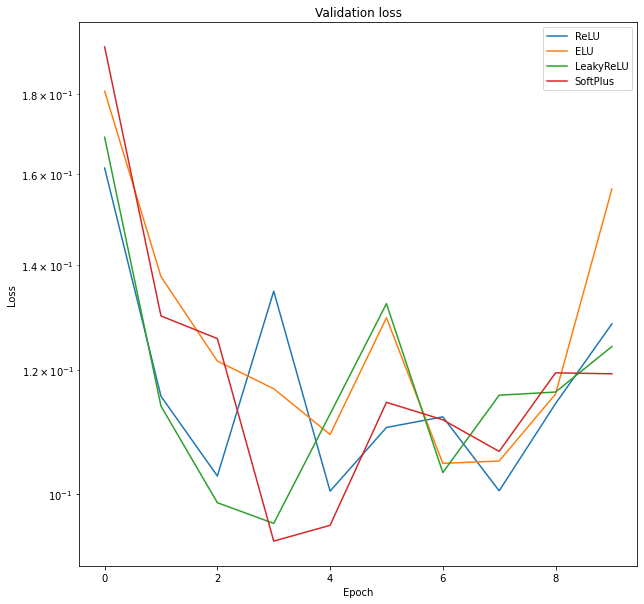

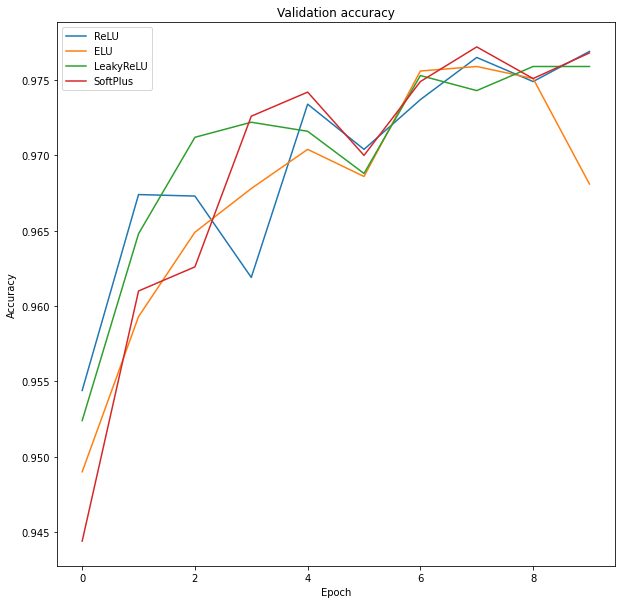

In [40]:
plot_results(np.array(train_losses), np.array(val_losses), np.array(val_accuracies), labels)

Применение Adam optimizer-а улучшило качество модели, точность теперь 97.7% при использовании LeakyReLU и 97.5% при использовании ReLU.

### Batch Normalisation with SGD momentum


In [41]:
activation_funcs = [ReLU, ELU, LeakyReLU, SoftPlus]
train_losses = []
val_losses = []
val_accuracies = []
n_epoch = 10
batch_size = 512
optimizer_config = {'learning_rate' : 1e-2, 'momentum': 0.9, 'beta1': 0.3, 'beta2': 0.9, 'epsilon': 1e-8}
criterion = ClassNLLCriterion()

labels = ["ReLU", "ELU", "LeakyReLU", "SoftPlus"]
for i, activation_func in enumerate(activation_funcs):
    net = build_model_batch_norm(activation_func)
    train_loss, val_loss, val_acc, time = train(net, adam_optimizer, optimizer_config, criterion, X_train, y_train, X_val, y_val, n_epoch, batch_size)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    net.evaluate()
    preds = net.forward(X_test)
    test_acc = accuracy_score([np.argmax(i) for i in preds], [np.argmax(i) for i in y_test])
    print(f'{labels[i]}: Test accuracy: {test_acc}. Execution time per epoch: {time/n_epoch}.')



ReLU: Test accuracy: 0.9732. Execution time per epoch: 0:00:02.878390.
ELU: Test accuracy: 0.9715. Execution time per epoch: 0:00:03.396806.
LeakyReLU: Test accuracy: 0.9766. Execution time per epoch: 0:00:02.942263.
SoftPlus: Test accuracy: 0.9699. Execution time per epoch: 0:00:03.627655.


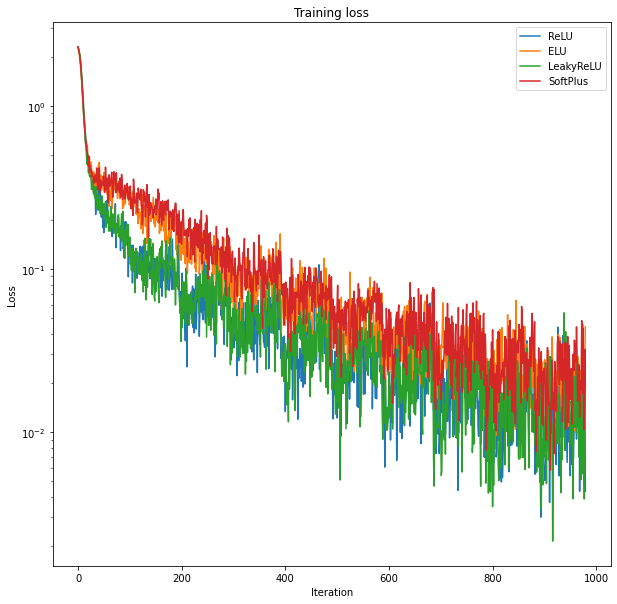

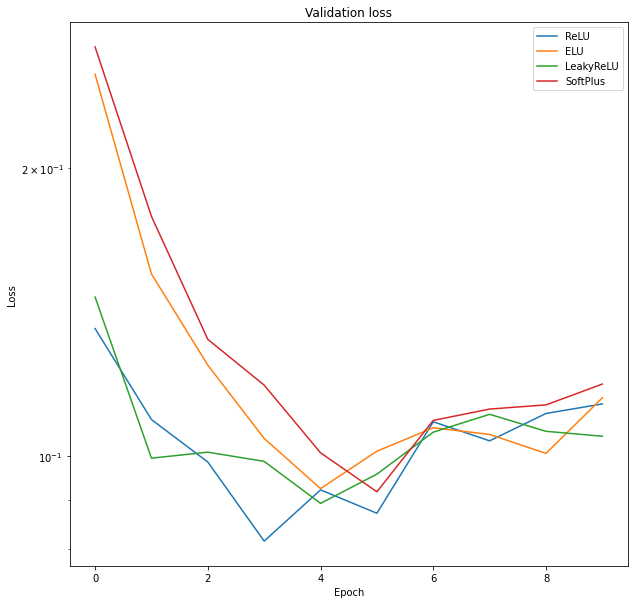

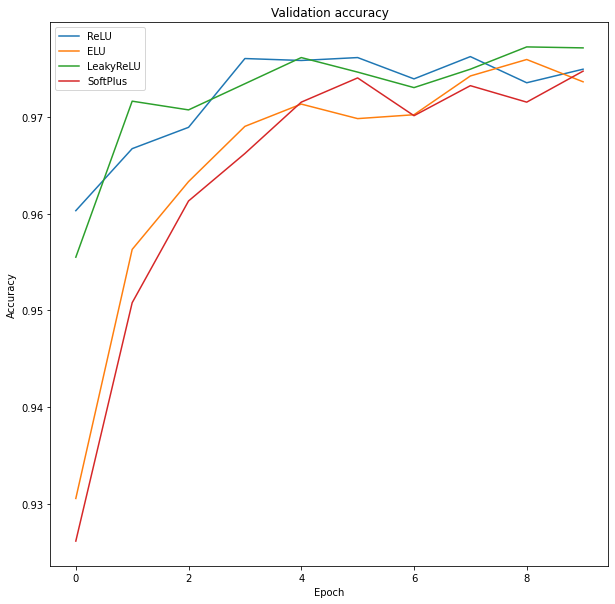

In [42]:
plot_results(np.array(train_losses), np.array(val_losses), np.array(val_accuracies), labels)

В данном случае измененя в accuracy по сравненю с прошлым эксперментом практчески не заметно. Но графики обученя стал несколько сглаженней.

### Best model

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [43]:
def build_best_model(input_size=28*28, output_size=10):
    net = Sequential()
    net.add(Linear(input_size, 256))
    net.add(Dropout(0.2))
    net.add(ReLU())
    net.add(BatchNormalization())
    net.add(ChannelwiseScaling(256))
    net.add(Linear(256, 128))
    net.add(Dropout(0.2))
    net.add(ReLU())
    net.add(BatchNormalization())
    net.add(ChannelwiseScaling(128))
    net.add(Linear(128, output_size))
    net.add(LogSoftMax())
    
    return net

In [45]:
n_epoch = 10
batch_size = 512
optimizer_config = {'learning_rate' : 1e-2, 'momentum': 0.9, 'beta1': 0.3, 'beta2': 0.9, 'epsilon': 1e-8}
criterion = ClassNLLCriterion()

net = build_best_model()
train_loss, val_loss, val_acc, time = train(net, adam_optimizer, optimizer_config, criterion, X_train, y_train, X_val, y_val, n_epoch, batch_size)
net.evaluate()
preds = net.forward(X_test)
test_acc = accuracy_score([np.argmax(i) for i in preds], [np.argmax(i) for i in y_test])
print(f'Test accuracy: {test_acc}. Execution time per epoch: {time/n_epoch}.')


Test accuracy: 0.98. Execution time per epoch: 0:00:06.150826.


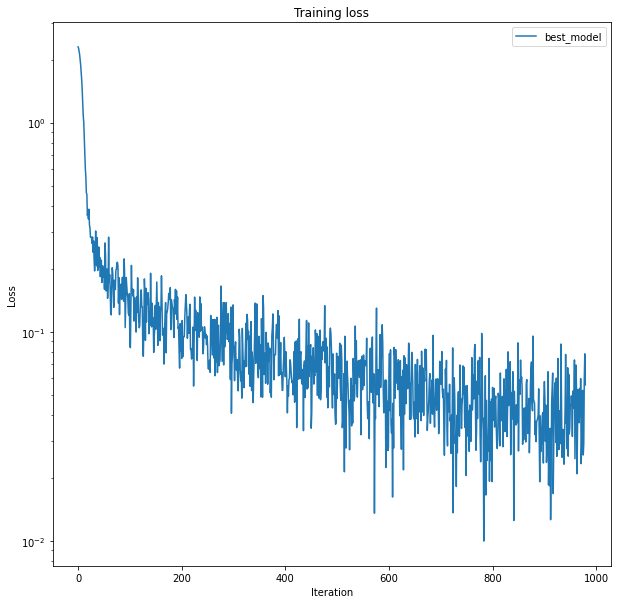

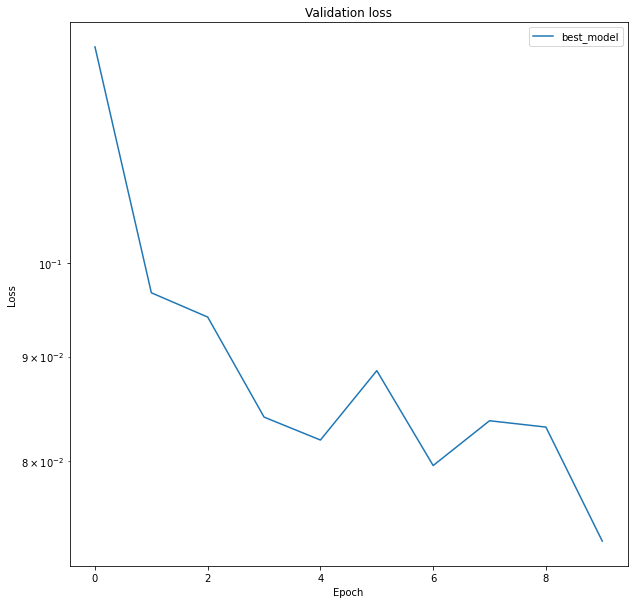

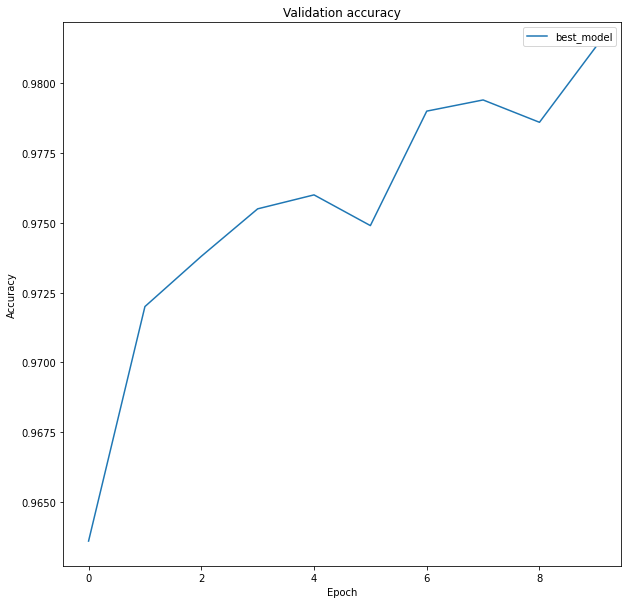

In [46]:
plot_results([train_loss], [val_loss], [val_acc], ['best_model'])

Print here your accuracy on test set. It should be around 90%.

In [49]:
# Your answer goes here. ################################################
print(f'Test accuracy: {test_acc}.')

Test accuracy: 0.98.


На лучшей модели с примененем большего числа линейных слоёв, BatchNormalization и Dropout удалось добиться значения accuracy на тестовой выборке 98%. Это очень высокий показатель.

Одна эпоха длится примерно 6.15 секунды. 

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [50]:
# Your beautiful code here.
import torch

best = torch.nn.Sequential( 
    torch.nn.Linear(28 * 28, 256),
    torch.nn.Dropout(0.2),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(256, 0.0),
    torch.nn.Linear(256, 128),
    torch.nn.Dropout(0.2),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(128, 0.0),
    torch.nn.Linear(128, 10),
    torch.nn.LogSoftmax(dim=1)
)
optimizer = torch.optim.Adam(best.parameters(), lr = 1e-2)

In [66]:
def train_torch(model, criterion, optimizer, X, y, X_val, y_val, n_epoch, batch_size):
    train_loss = []
    val_loss = []
    val_acc = []

    start = datetime.now()
    for i in range(n_epoch):
        model.train(True)
        for x_batch, y_batch in get_batches((X, y), batch_size):

            # Forward
            predictions = model.forward(torch.tensor(x_batch))
            loss = criterion(predictions, torch.tensor(np.argmax(y_batch, axis = 1)))

            # Backward
            loss.backward()

            # Update weights
            optimizer.step() 
            optimizer.zero_grad()

            train_loss.append(loss.item())
          
        model.train(False)
        with torch.no_grad():
            y_pred = model(torch.tensor(X_val))
            loss_cur = criterion(y_pred, torch.tensor(np.argmax(y_val, axis = 1)))
            val_loss.append(loss_cur.item())
            val_acc.append(accuracy_score([np.argmax(i) for i in y_pred.detach().numpy()], [np.argmax(i) for i in y_val]))
                
    end = datetime.now() - start
    return train_loss, val_loss, val_acc, time

In [73]:
n_epoch = 10
batch_size = 512
train_loss, val_loss, val_acc, time = train_torch(best, torch.nn.functional.nll_loss, optimizer, X_train, y_train, X_val, y_val, n_epoch, batch_size)

In [74]:
y_pred = best(torch.tensor(X_test))
print(f'Test accuracy: {accuracy_score([np.argmax(i) for i in y_pred.detach().numpy()], [np.argmax(i) for i in y_test])}')
print(f'Time per epoch: {time/n_epoch}')

Test accuracy: 0.9814
Time per epoch: 0:00:06.150826


Аналогичная архитектура сети, реализованная средствами PyTorch при аналогичных параметрах обучения выдаёт accuracy 98.14% на тестовой выборке. Это говорит о том, что наша реализация показывает сравнимые с PyTorch результаты. 

При этом время выполнения одной эпохи в PyTorch равно 6.15 секунды, что совпадает с показателеми при применении реализованных нами модулей.